# ABS Headline Macroeconomic Indicator VAR Model
The below script implements a Vector Autoregression (VAR) for the three key headline macroeconomic indicators reported by the Australian Bureau of Statistics (ABS). 

A lot of this code is sourced directly from this post on "Machine Learning +": https://www.machinelearningplus.com/time-series/vector-autoregression-examples-python/.


In [96]:
%reset -f

In [97]:
import pandas            as pd
import matplotlib.pyplot as plt
import matplotlib.dates  as mdates
import seaborn           as sns
import numpy             as np
import statsmodels.api   as sm

from statsmodels.tsa.api                 import VAR
from statsmodels.tsa.stattools           import adfuller
from statsmodels.tsa.vector_ar.var_model import VARResults
from statsmodels.tools.eval_measures     import rmse, aic
from statsmodels.tsa.stattools           import grangercausalitytests
from statsmodels.tsa.vector_ar.vecm      import coint_johansen
from statsmodels.stats.stattools         import durbin_watson
from statsmodels.tsa.stattools           import acf
from sklearn.metrics                     import r2_score

### Load data

In [98]:
df = pd.read_csv("Macroeconomic Indicators.csv")
#df = pd.read_csv("Macroeconomic Indicators.csv", parse_dates=['Date'], index_col='Date')

In [99]:
df.index = pd.date_range(start='1978-03', periods=183, freq='Q')

#df['time'] = pd.to_datetime(df['Date'])
#df = df.sort_values('time')
#df = df.set_index('time', inplace=True)
#df = df.reset_index()
df = df.dropna()

In [100]:
df.tail()

,Date,Year,Month,Quarter,CPI,GDP,GDP_2,UNEMP
2022-06-30,1/06/2022,2022,6,2,6.1,0.7,3.1,3.576119
2022-09-30,1/09/2022,2022,9,3,7.3,0.7,5.9,3.581065
2022-12-31,1/12/2022,2022,12,4,7.8,0.7,2.7,3.528630
2023-03-31,1/03/2023,2023,3,1,7.0,0.4,2.5,3.523359
2023-06-30,1/06/2023,2023,6,2,6.0,0.4,2.2,3.463568


# Exploratory Data Analysis
This section will explore stationarity of each key time series.

In [101]:
df1 = pd.DataFrame()
df2 = pd.DataFrame()
df3 = pd.DataFrame()

df1['data'] = df['CPI']
df2['data'] = df['GDP_2']
df3['data'] = df['UNEMP']

In [102]:
def plot_rolling(df,name):
    
    df['z_data'] = (df['data'] - df.data.rolling(window=4).mean()) / df.data.rolling(window=4).std()
    df['zp_data'] = df['z_data'] - df['z_data'].shift(1)
    df['zs_data'] = df['z_data'] - df['z_data'].shift(4)
    
    fig, ax = plt.subplots(4,figsize=(12, 9))
    ax[0].scatter(df.index, df.data, color='c', label=name)
    ax[0].plot(df.data.rolling(window=4).mean(), color='b', label="moving avergae");
    ax[0].plot(df.data.rolling(window=4).std(), color='r', label="moving std");
    ax[0].legend()

    ax[1].scatter(df.index, df.z_data, color='c', label="de-trended "+name)
    ax[1].plot(df.z_data.rolling(window=4).mean(), color='b', label="moving aveage");
    ax[1].plot(df.z_data.rolling(window=4).std(), color='r', label="moving std");
    ax[1].legend()

    ax[2].scatter(df.index, df.zp_data, color='c', label="1 lag differenced de-trended "+name)
    ax[2].plot(df.zp_data.rolling(window=4).mean(), color='b', label="moving average");
    ax[2].plot(df.zp_data.rolling(window=4).std(), color='r', label="moving std");
    ax[2].legend()
    
    ax[3].scatter(df.index, df.zs_data, color='c', label="seasonal differenced de-trended "+name)
    ax[3].plot(df.zs_data.rolling(window=4).mean(), color='b', label="moving average");
    ax[3].plot(df.zs_data.rolling(window=4).std(), color='r', label="moving std");
    ax[3].legend()

    plt.tight_layout()
    fig.autofmt_xdate()
    

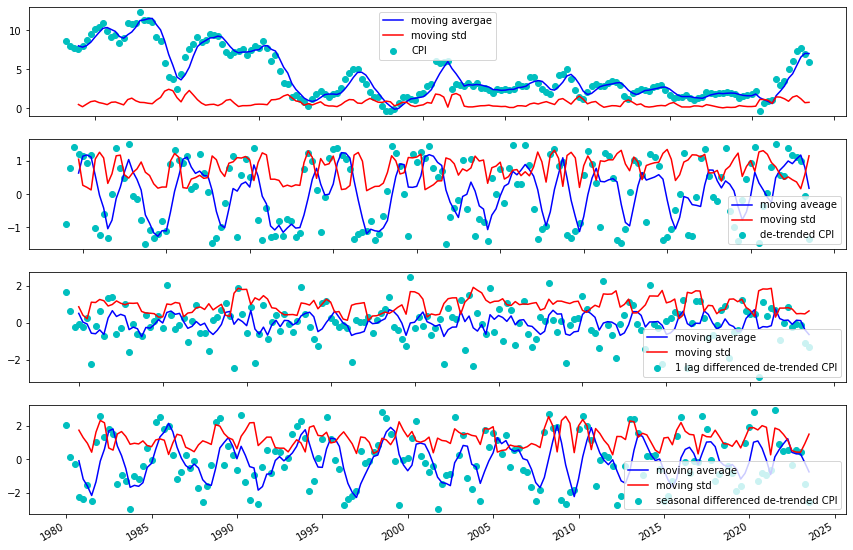

In [103]:
plot_rolling(df1,'CPI')

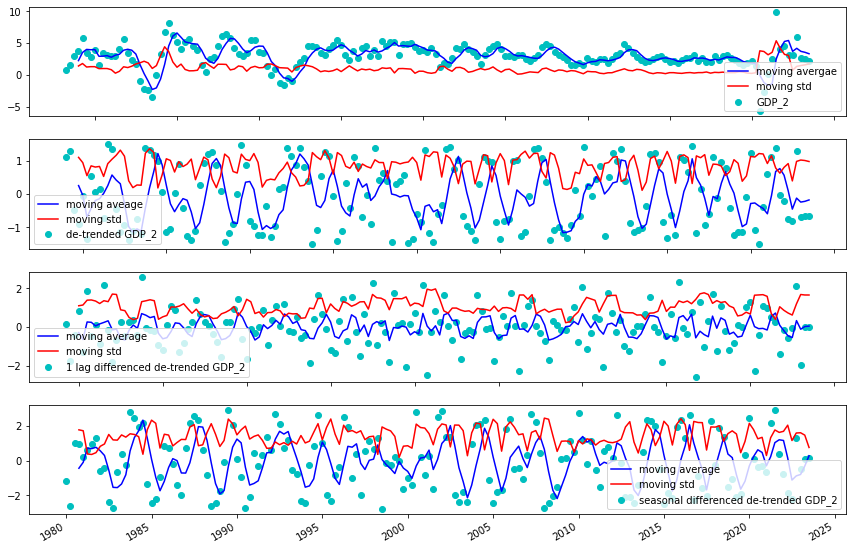

In [104]:
plot_rolling(df2,'GDP_2')

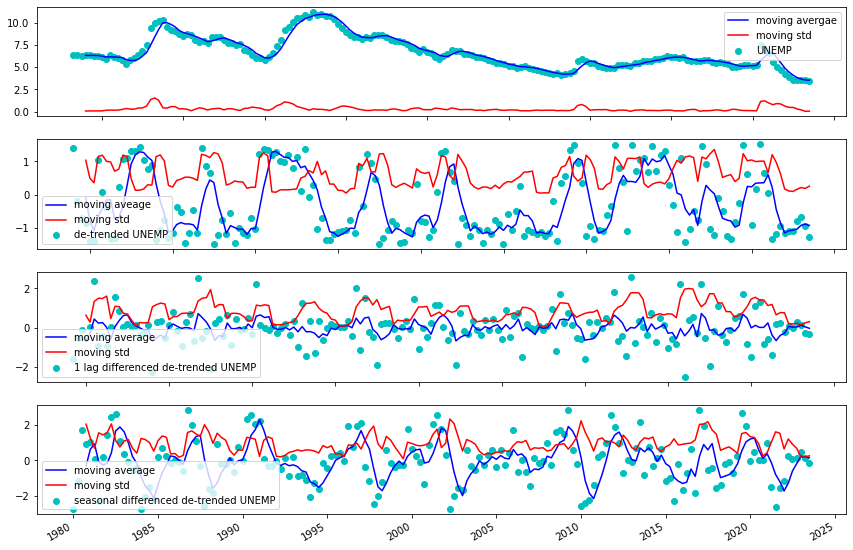

In [105]:
plot_rolling(df3,'UNEMP')

### Augmented Dickey-Fuller Tests for Stationarity

In [106]:
def adf_test(df,name):
    
    print("-----------------------------------------")
    print("for variable " + name)
    print("-----------------------------------------")
    
    dftest = adfuller(df.data.dropna(), autolag='BIC')
    print("Test statistic = {:.3f}".format(dftest[0]))
    print("P-value = {:.3f}".format(dftest[1]))
    print("Critical values :")
    for k, v in dftest[4].items():
        print("\t{}: {} - The data is {} stationary with {}% confidence".format(k, v, "not" if v<dftest[0] else "", 100-int(k[:-1])))

    print("\n > Is the de-trended data stationary ?")
    dftest = adfuller(df.z_data.dropna(), autolag='AIC')
    print("Test statistic = {:.3f}".format(dftest[0]))
    print("P-value = {:.3f}".format(dftest[1]))
    print("Critical values :")
    for k, v in dftest[4].items():
        print("\t{}: {} - The data is {} stationary with {}% confidence".format(k, v, "not" if v<dftest[0] else "", 100-int(k[:-1])))

    print("\n > Is the 1-lag differenced de-trended data stationary ?")
    dftest = adfuller(df.zp_data.dropna(), autolag='AIC')
    print("Test statistic = {:.3f}".format(dftest[0]))
    print("P-value = {:.3f}".format(dftest[1]))
    print("Critical values :")
    for k, v in dftest[4].items():
        print("\t{}: {} - The data is {} stationary with {}% confidence".format(k, v, "not" if v<dftest[0] else "", 100-int(k[:-1])))
    
    print("\n > Is the seasonal differenced de-trended data stationary ?")
    dftest = adfuller(df.zs_data.dropna(), autolag='AIC')
    print("Test statistic = {:.3f}".format(dftest[0]))
    print("P-value = {:.3f}".format(dftest[1]))
    print("Critical values :")
    for k, v in dftest[4].items():
        print("\t{}: {} - The data is {} stationary with {}% confidence".format(k, v, "not" if v<dftest[0] else "", 100-int(k[:-1])))

In [107]:
adf_test(df1,'CPI')

-----------------------------------------
for variable CPI
-----------------------------------------
Test statistic = -2.142
P-value = 0.228
Critical values :
	1%: -3.467845319799907 - The data is not stationary with 99% confidence
	5%: -2.878011745497439 - The data is not stationary with 95% confidence
	10%: -2.575551186759871 - The data is not stationary with 90% confidence

 > Is the de-trended data stationary ?
Test statistic = -6.711
P-value = 0.000
Critical values :
	1%: -3.4691814633722453 - The data is  stationary with 99% confidence
	5%: -2.878595143532943 - The data is  stationary with 95% confidence
	10%: -2.5758625549741803 - The data is  stationary with 90% confidence

 > Is the 1-lag differenced de-trended data stationary ?
Test statistic = -7.898
P-value = 0.000
Critical values :
	1%: -3.469648263987657 - The data is  stationary with 99% confidence
	5%: -2.878798906308495 - The data is  stationary with 95% confidence
	10%: -2.5759713094779593 - The data is  stationary wi

In [108]:
adf_test(df2,'GDP_2') 

-----------------------------------------
for variable GDP_2
-----------------------------------------
Test statistic = -5.557
P-value = 0.000
Critical values :
	1%: -3.4680615871598537 - The data is  stationary with 99% confidence
	5%: -2.8781061899535128 - The data is  stationary with 95% confidence
	10%: -2.5756015922004134 - The data is  stationary with 90% confidence

 > Is the de-trended data stationary ?
Test statistic = -6.066
P-value = 0.000
Critical values :
	1%: -3.470126426071447 - The data is  stationary with 99% confidence
	5%: -2.8790075987120027 - The data is  stationary with 95% confidence
	10%: -2.5760826967621644 - The data is  stationary with 90% confidence

 > Is the 1-lag differenced de-trended data stationary ?
Test statistic = -6.448
P-value = 0.000
Critical values :
	1%: -3.471118535474365 - The data is  stationary with 99% confidence
	5%: -2.8794405060097024 - The data is  stationary with 95% confidence
	10%: -2.576313761526591 - The data is  stationary with 9

In [109]:
adf_test(df3,'UNEMP')

-----------------------------------------
for variable UNEMP
-----------------------------------------
Test statistic = -2.176
P-value = 0.215
Critical values :
	1%: -3.4674201432469816 - The data is not stationary with 99% confidence
	5%: -2.877826051844538 - The data is not stationary with 95% confidence
	10%: -2.575452082332012 - The data is not stationary with 90% confidence

 > Is the de-trended data stationary ?
Test statistic = -5.403
P-value = 0.000
Critical values :
	1%: -3.467845319799907 - The data is  stationary with 99% confidence
	5%: -2.878011745497439 - The data is  stationary with 95% confidence
	10%: -2.575551186759871 - The data is  stationary with 90% confidence

 > Is the 1-lag differenced de-trended data stationary ?
Test statistic = -6.291
P-value = 0.000
Critical values :
	1%: -3.4703698981001665 - The data is  stationary with 99% confidence
	5%: -2.8791138497902193 - The data is  stationary with 95% confidence
	10%: -2.576139407751488 - The data is  stationary 

# Modelling
In this section I will explore the key modelling decisions for the VAR approach. This includes;
- Spliting the data into train and test sets
- difference the training set
- select the order of the $VAR(p)$ model
- a function for key $VAR$ outputs

### Split into training and test date

In [110]:
df_split = df[['CPI','GDP_2','UNEMP']]

nobs = 4
df_train, df_test = df_split[0:-nobs], df_split[-nobs:]

# Check size
print(df_train.shape) 
print(df_test.shape) 

(178, 3)
(4, 3)


### Difference the data

In [111]:
#df_train['CPI']  = df_train['CPI'].diff(1)
#df_train['UNEMP'] = df_train['UNEMP'].diff(1)
#df_train = df_train.rename(columns={"CPI" : "D1_CPI"})
#df_train = df_train.rename(columns={"UNEMP"  : "D1_UNEMP"})
#df_train = df_train.dropna()

df_differenced = df_train.diff(1).dropna()

df_differenced.tail()

,CPI,GDP_2,UNEMP
2021-06-30,2.7,7.4,-0.633436
2021-09-30,-0.8,-5.9,-0.298317
2021-12-31,0.5,0.6,-0.499106
2022-03-31,1.6,-1.5,-0.258792
2022-06-30,1.0,0.0,-0.342458


### Select Model Order 
$p\in {1:12}$

In [112]:
x = VAR(df_train).select_order(maxlags=12)
x.summary()

,AIC,BIC,FPE,HQIC
0,4.655,4.711,105.1,4.678
1,-2.014,-1.789,0.1335,-1.922
2,-2.264,-1.870*,0.1040,-2.104
3,-2.348,-1.786,0.09557,-2.120
4,-2.280,-1.549,0.1024,-1.983
5,-2.575,-1.675,0.07633,-2.209*
6,-2.573,-1.504,0.07656,-2.139
7,-2.507,-1.269,0.08192,-2.005
8,-2.482,-1.076,0.08415,-1.911
9,-2.590*,-1.015,0.07576*,-1.951


I will use BIC when selecting the order of var. The following function:
- trains the VAR model
- reports the training result
- plot the input processes
- plot the acf
- plot the irf (point and cumulative)
- plot cumulative effects
- do Granger tests
- compute Ljung-Box test

You only need to input the dataframe "df" and set the lag number "i"

In [113]:
def var_est(df,i):
    
    print("---------------------------------------------")
    print("VAR result for max lag = " + str(i))
    print("---------------------------------------------")
    
    model  = VAR(df)
    result = model.fit(i, trend='c')
    
    print(result.summary())
    
    #print("---------------------------------------------")
    #print("Plotting input time series")
    #print("---------------------------------------------")
    
    #result.plot()
    #plt.show()
    
    print("---------------------------------------------")
    print("Plotting time series autocorrelation function")
    print("---------------------------------------------")
          
    result.plot_acorr()
    plt.show()
    
    print("---------------------------------------------")
    print("Plotting IRF")
    print("---------------------------------------------")
    
    irf = result.irf(10)
    irf.plot(orth=False)
    plt.show()
    
    print("---------------------------------------------")
    print("Plotting cumulative effects")
    print("---------------------------------------------")
    
    irf.plot_cum_effects(orth=False)
    plt.show()
    
    print("---------------------------------------------")
    print("Granger test")
    print("---------------------------------------------")
    
    test_result1 = result.test_causality('CPI', ['GDP_2', 'UNEMP'], kind='f')
    print(test_result1.summary())
    
    test_result2 = result.test_causality('GDP_2', ['CPI', 'UNEMP'], kind='f')
    print(test_result2.summary())
    
    test_result3 = result.test_causality('UNEMP', ['CPI', 'GDP_2'], kind='f')
    print(test_result3.summary())
    
    print("---------------------------------------------")
    print("Ljung-Box test for VAR")
    print("---------------------------------------------")
    test_result4 = result.test_whiteness()
    print(test_result4.summary())
    
    
    print("---------------------------------------------")
    print("Johanssen Cointegration Test")
    print("---------------------------------------------")   
    
    coint_johansen_result = coint_johansen(df, det_order=0, k_ar_diff=1)
    # Get the trace and eigenvalue statistics
    trace_statistic = coint_johansen_result.lr1
    eigenvalue_statistic = coint_johansen_result.lr2

    # Get the critical values at certain significance levels
    critical_values_90 = coint_johansen_result.cvm[:, 0]
    critical_values_95 = coint_johansen_result.cvm[:, 1]
    critical_values_99 = coint_johansen_result.cvm[:, 2]

    # Print the results
    print("Trace Statistic:", trace_statistic)
    print("Eigenvalue Statistic:", eigenvalue_statistic)
    print("\nCritical Values (90%):", critical_values_90)
    print("Critical Values (95%):", critical_values_95)
    print("Critical Values (99%):", critical_values_99)
        
    # Compare the test statistics with critical values to make a decision
    if trace_statistic[0] > critical_values_90[0]:
        print("\nReject the null hypothesis of no cointegration at 90% confidence level.")
    else:
        print("\nFail to reject the null hypothesis of no cointegration at 90% confidence level.")
        
        
    print("---------------------------------------------")
    print("Check Eigenvalues for Stability of System")
    print("---------------------------------------------") 
    result.is_stable(verbose =1)
    
    print("---------------------------------------------")
    print("Durbin Watson Test for Serial Correlation in Errors")
    print("---------------------------------------------")     
    print(durbin_watson(result.resid))
    

---------------------------------------------
VAR result for max lag = 2
---------------------------------------------
  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Thu, 21, Dec, 2023
Time:                     17:28:04
--------------------------------------------------------------------
No. of Equations:         3.00000    BIC:                   -1.54912
Nobs:                     175.000    HQIC:                  -1.77484
Log likelihood:          -555.165    FPE:                   0.145328
AIC:                     -1.92889    Det(Omega_mle):        0.129196
--------------------------------------------------------------------
Results for equation CPI
              coefficient       std. error           t-stat            prob
---------------------------------------------------------------------------
const           -0.015310         0.062722           -0.244           0.807
L1.CPI           0.066800         0.077

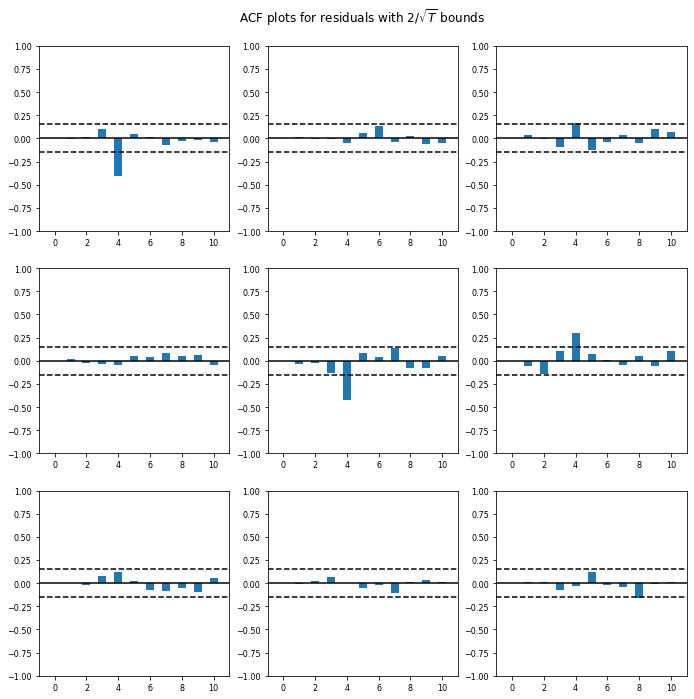

---------------------------------------------
Plotting IRF
---------------------------------------------


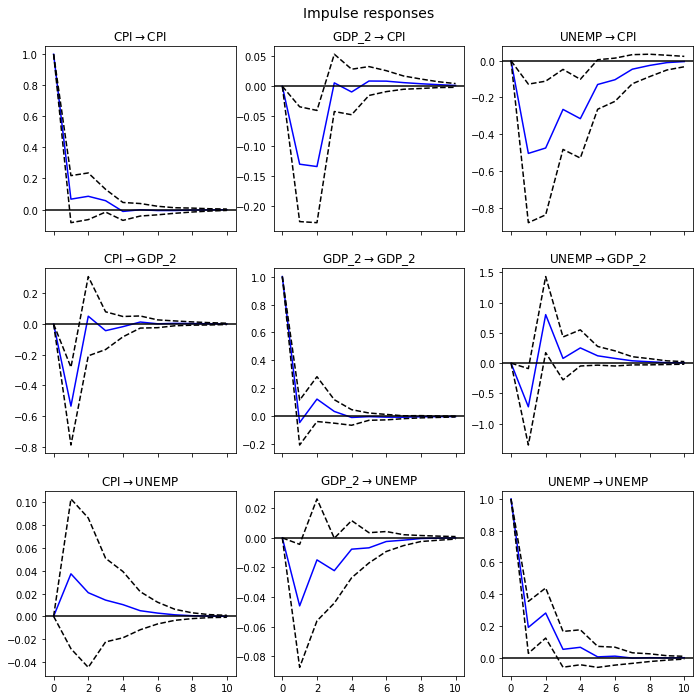

---------------------------------------------
Plotting cumulative effects
---------------------------------------------


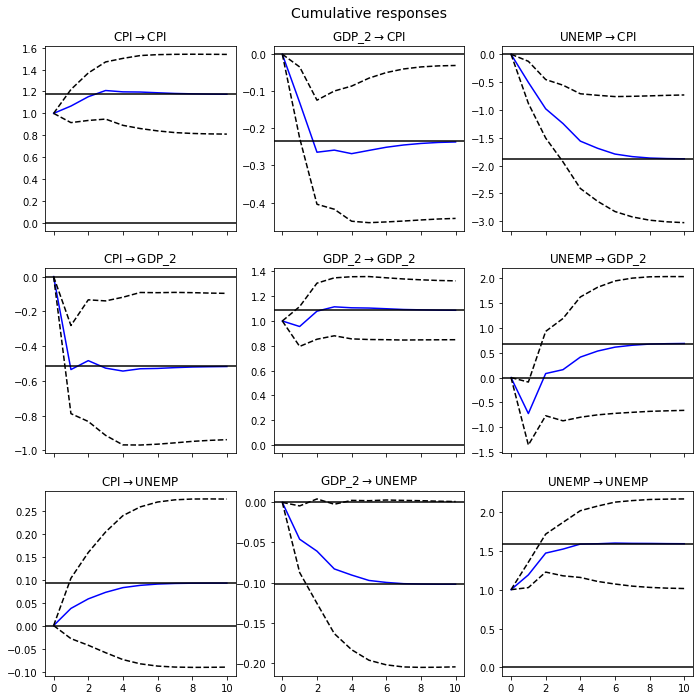

---------------------------------------------
Granger test
---------------------------------------------
Granger causality F-test. H_0: ['GDP_2', 'UNEMP'] do not Granger-cause CPI. Conclusion: reject H_0 at 5% significance level.
Test statistic Critical value p-value    df   
----------------------------------------------
         5.051          2.390   0.001 (4, 504)
----------------------------------------------
Granger causality F-test. H_0: ['CPI', 'UNEMP'] do not Granger-cause GDP_2. Conclusion: reject H_0 at 5% significance level.
Test statistic Critical value p-value    df   
----------------------------------------------
         6.064          2.390   0.000 (4, 504)
----------------------------------------------
Granger causality F-test. H_0: ['CPI', 'GDP_2'] do not Granger-cause UNEMP. Conclusion: fail to reject H_0 at 5% significance level.
Test statistic Critical value p-value    df   
----------------------------------------------
         1.563          2.390   0.183 (4, 

In [114]:
#var_est(df_train,1)
var_est(df_differenced,2)

# Forecasts
In this section I will use the trained model to forecast each series.

In [115]:
model  = VAR(df_train)
model_fitted = model.fit(2, trend='c')

In [116]:
lag_order = model_fitted.k_ar
print(lag_order)

2


In [117]:
forecast_input = df_differenced.values[-lag_order:]
forecast_input

array([[ 1.6      , -1.5      , -0.2587918],
       [ 1.       ,  0.       , -0.3424579]])

In [118]:
fc = model_fitted.forecast(y=forecast_input, steps=nobs)
#df_forecast = pd.DataFrame(fc, index=df_differenced.index[-nobs:], columns=df_differenced.columns + '_1d')
df_forecast = pd.DataFrame(fc, index=df_test.index, columns=df_differenced.columns + '_1d')
df_forecast

,CPI_1d,GDP_2_1d,UNEMP_1d
2022-09-30,0.875729,1.033760,-0.230197
2022-12-31,0.903124,1.047957,-0.102042
2023-03-31,1.080604,0.927391,0.056060
2023-06-30,1.272900,0.751029,0.228666


In [119]:
def invert_transformation(df_train, df_forecast, second_diff=False):
    """Revert back the differencing to get the forecast to original scale."""
    df_fc = df_forecast.copy()
    columns = df_train.columns
    for col in columns:        
        df_fc[str(col)+'_forecast'] = df_train[col].iloc[-1] + df_fc[str(col)+'_1d'].cumsum()
    return df_fc

In [120]:
df_results = invert_transformation(df_train, df_forecast, second_diff=False)        
df_results.loc[:, ['CPI_forecast', 'GDP_2_forecast', 'UNEMP_forecast']]

,CPI_forecast,GDP_2_forecast,UNEMP_forecast
2022-09-30,6.975729,4.133760,3.345922
2022-12-31,7.878854,5.181717,3.243880
2023-03-31,8.959458,6.109108,3.299940
2023-06-30,10.232358,6.860137,3.528606


In [121]:
#df_results = np.cumsum(fc, axis=0) + df[['CPI','GDP_2','UNEMP']].values[-1]

In [122]:
#print(df_results)

### Forecast vs Actual Plot Comparison

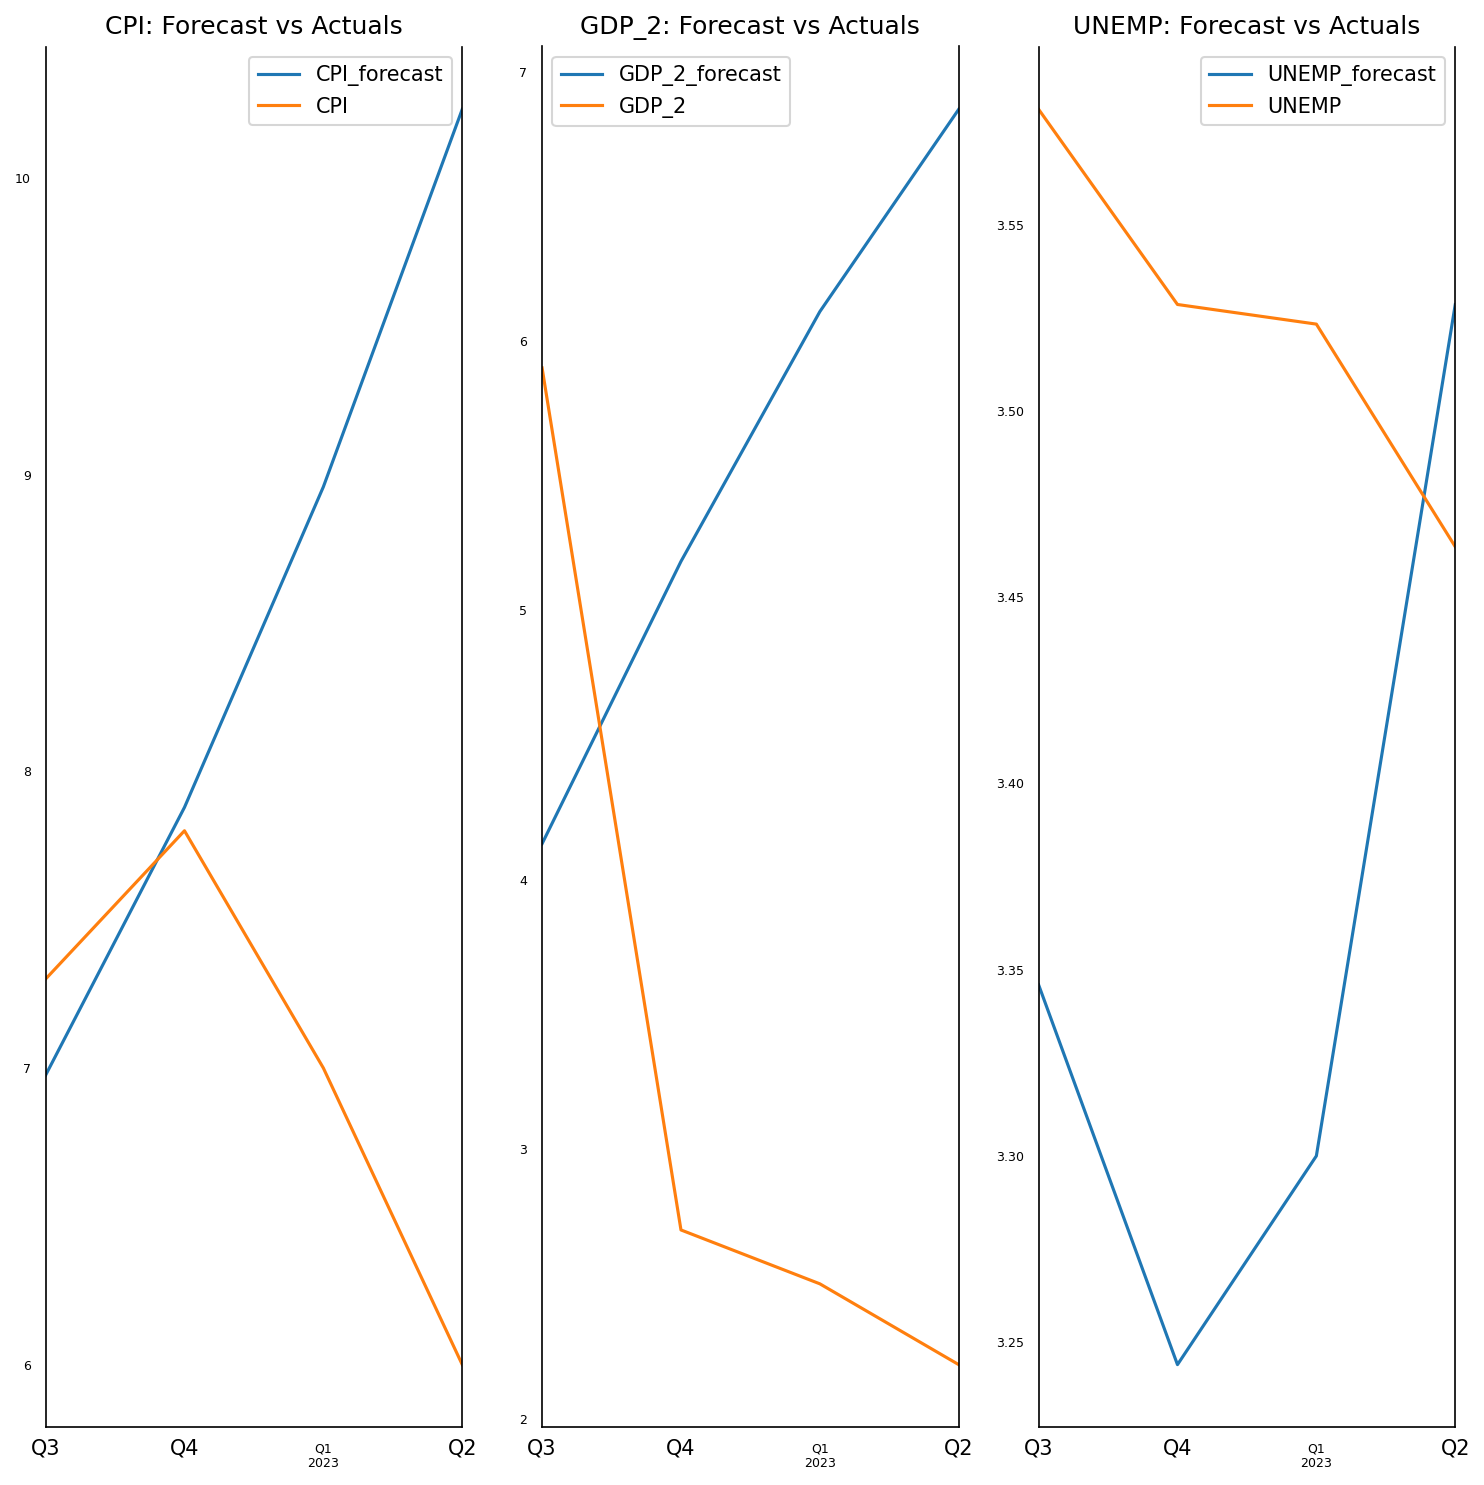

In [123]:
fig, axes = plt.subplots(nrows=int(len(df_train.columns)/2), ncols=3, dpi=150, figsize=(10,10))
for i, (col,ax) in enumerate(zip(df_train.columns, axes.flatten())):
    df_results[col+'_forecast'].plot(legend=True, ax=ax).autoscale(axis='x',tight=True)
    df_test[col][-nobs:].plot(legend=True, ax=ax);
    ax.set_title(col + ": Forecast vs Actuals")
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.tight_layout();

# Evaluate Models

In [124]:
def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
    me = np.mean(forecast - actual)             # ME
    mae = np.mean(np.abs(forecast - actual))    # MAE
    mpe = np.mean((forecast - actual)/actual)   # MPE
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
    corr = np.corrcoef(forecast, actual)[0,1]   # corr
    mins = np.amin(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    maxs = np.amax(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    minmax = 1 - np.mean(mins/maxs)             # minmax
    #r2 = r2_score(actual, forecast)
    return({'mape':mape, 'me':me, 'mae': mae, 
            'mpe': mpe, 'rmse':rmse, 'corr':corr, 'minmax':minmax#, 'R^2':r2
           })

In [125]:
['CPI_forecast', 'GDP_2_forecast', 'UNEMP_forecast']

print('Forecast Accuracy of: CPI')
CPI_Metrics = forecast_accuracy(df_results['CPI_forecast'].values, df_test['CPI'])
for k, v in CPI_Metrics.items():
    print(k, ': ', round(v,4))

print('\nForecast Accuracy of: GDP')
GDP_Metrics = forecast_accuracy(df_results['GDP_2_forecast'].values, df_test['GDP_2'])
for k, v in GDP_Metrics.items():
    print(k, ': ', round(v,4))

print('\nForecast Accuracy of: UNEMP')
UNEMP_Metrics = forecast_accuracy(df_results['UNEMP_forecast'].values, df_test['UNEMP'])
for k, v in UNEMP_Metrics.items():
    print(k, ': ', round(v,4))


Forecast Accuracy of: CPI
mape :  0.26
me :  1.4866
mae :  1.6487
mpe :  0.2378
rmse :  2.3379
corr :  -0.8404
minmax :  0.1717

Forecast Accuracy of: GDP
mape :  1.1951
me :  2.2462
mae :  3.1293
mpe :  1.0454
rmse :  3.3174
corr :  -0.8753
minmax :  0.5121

Forecast Accuracy of: UNEMP
mape :  0.0571
me :  -0.1696
mae :  0.2021
mpe :  -0.0477
rmse :  0.2182
corr :  -0.6463
minmax :  0.0571


<ipython-input-124-009da08afeb7>:9: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  actual[:,None]]), axis=1)
<ipython-input-124-009da08afeb7>:11: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  actual[:,None]]), axis=1)


This model really doesn't perform well at all. A better approach is necessary. This could be adding other time series variables to this model to increase the complexity or through machine learning methods.